# Strangers with Candy run Ragnar 2016

In this notebook, I use pymc to sample from models of our ragnar runners' expected performance, in order to try to predict exchange times.
Right now, point estimates are used to shape normal curves for the performance models.  PYMC would allow, however, for a more complex model, and even incorporation of observed data in order to influence our prior with a likelihood so that the posterior, our pace estimates, more accurately reflect our performance on race day.

### Exchange timing estimates

In [131]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

from datetime import datetime, timedelta

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import string

In [132]:
sns.set_context("notebook", font_scale=1.25, rc={'figure.figsize':(14,8)})

In [133]:
init_paces = pd.DataFrame([
    {'position':1, 'name':'David', 'pace':9.25},
    {'position':2, 'name':'Anna', 'pace':9.75},
    {'position':3, 'name':'Kevin', 'pace':8.83},
    {'position':4, 'name':'Christine', 'pace':9.5},
    {'position':5, 'name':'Daniel', 'pace':8.0},
    {'position':6, 'name':'Jason', 'pace':9.75},
    
    {'position':7, 'name':'Valerie', 'pace':8.83},
    {'position':8, 'name':'Patrick', 'pace':8.75},
    {'position':9, 'name':'Mark', 'pace':10.83},
    {'position':10, 'name':'Chris', 'pace':8.33},
    {'position':11, 'name':'Casey', 'pace':9.75},
    {'position':12, 'name':'Rebecca', 'pace':12.5}
])
init_paces.set_index('position', inplace=True)

In [134]:
print init_paces

               name   pace
position                  
1             David   9.25
2              Anna   9.75
3             Kevin   8.83
4         Christine   9.50
5            Daniel   8.00
6             Jason   9.75
7           Valerie   8.83
8           Patrick   8.75
9              Mark  10.83
10            Chris   8.33
11            Casey   9.75
12          Rebecca  12.50


In [135]:
legs = pd.read_csv('ragnar-legs.csv')
legs.set_index('sequence', inplace=True)
legs.sort_index(inplace=True)
legs.head()

,distance,difficulty
sequence,,
1,6.70,Hard
2,3.58,Easy
3,8.62,Very Hard
4,3.22,Easy
5,7.30,Very Hard


## Estimating a single exchange time
Use pymc to sample from a normal random variable and then collect statistics on the result of a pace-to-time calculation using values from the sample trace.

In [136]:
pace_var = .25
pace_distr1 = pm.Normal("pace1", mu=init_paces.loc[1,'pace'], tau=1/(pace_var*pace_var))

In [137]:
pace1model = pm.Model([pace_distr1,])
mc1 = pm.MCMC(pacemodel)
mc1.sample(iter=9000, burn=2000, thin=5)

 [-----------------100%-----------------] 9000 of 9000 complete in 0.2 sec

In [138]:
print "pace1 Mean:%.04f Std:%.04f" % (np.mean(mc1.trace('pace1')[:]), np.std(mc1.trace('pace1')[:]))

pace1 Mean:9.7473 Std:0.2496


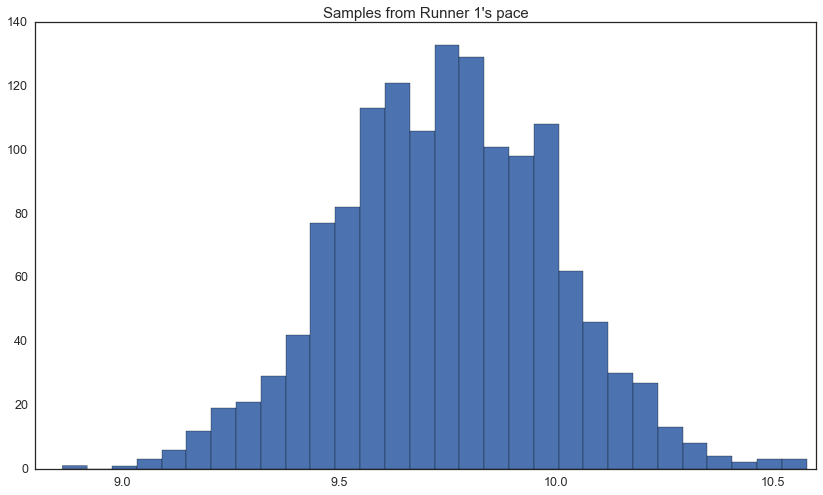

In [139]:
plt.hist(mc1.trace('pace1')[:], bins=30)
plt.title("Samples from Runner 1's pace")

In [103]:
exch1 = legs.loc[1,'distance']* np.array(mc.trace('pace1')[:])

In [104]:
exch1_interval = np.mean(exch1) + np.array([-2,0,2]) * np.std(exch1)

In [105]:
start_time = datetime(2016,5,13,6,30,0)

In [106]:
start_time.strftime("%d %B %Y %H:%M %p")

'13 May 2016 06:30 AM'

In [107]:
exch1_times = start_time + np.array([timedelta(minutes=t) for t in exch1_interval])

In [110]:
[t.strftime("%d %B %Y %H:%M %p") for t in exch1_times]

['13 May 2016 07:31 AM', '13 May 2016 07:35 AM', '13 May 2016 07:38 AM']

In [ ]:
np.ar

## Estimating all exchange times

In [113]:
pace_vars = np.zeros(len(init_paces)) + .25
pace_coll = [pm.Normal("pace%d" % (i+1,), mu=init_paces.loc[i+1,'pace'], tau=1/(pace_vars[i]*pace_vars[i])) for i in np.arange(len(init_paces))]
pace_distrs = pm.Container(pace_coll)

[<pymc.distributions.Normal 'pace1' at 0x0000000021815CC0>,
 <pymc.distributions.Normal 'pace2' at 0x00000000214A53C8>,
 <pymc.distributions.Normal 'pace3' at 0x0000000022D4D320>,
 <pymc.distributions.Normal 'pace4' at 0x0000000022EA5048>,
 <pymc.distributions.Normal 'pace5' at 0x0000000022EA5780>,
 <pymc.distributions.Normal 'pace6' at 0x0000000022EA5860>,
 <pymc.distributions.Normal 'pace7' at 0x0000000022EA5908>,
 <pymc.distributions.Normal 'pace8' at 0x0000000022EA59B0>,
 <pymc.distributions.Normal 'pace9' at 0x0000000022EA5A58>,
 <pymc.distributions.Normal 'pace10' at 0x0000000022EA5B00>,
 <pymc.distributions.Normal 'pace11' at 0x0000000022EA5BA8>,
 <pymc.distributions.Normal 'pace12' at 0x0000000021D8DEF0>]

In [115]:
pacesmodel = pm.Model(pace_distrs)
mc = pm.MCMC(pacesmodel)
mc.sample(iter=100000, burn=2000, thin=5)

 [-----------------100%-----------------] 100000 of 100000 complete in 16.8 sec

In [144]:
start_time + np.array([timedelta(minutes=t) for t in exch1_interval])
R = len(init_paces)
durations = [legs.loc[i+1,'distance'] * mc.trace('pace%d' % ((i%R)+1))[:] for i in np.arange(36)]
periods = np.cumsum(durations, axis=0)

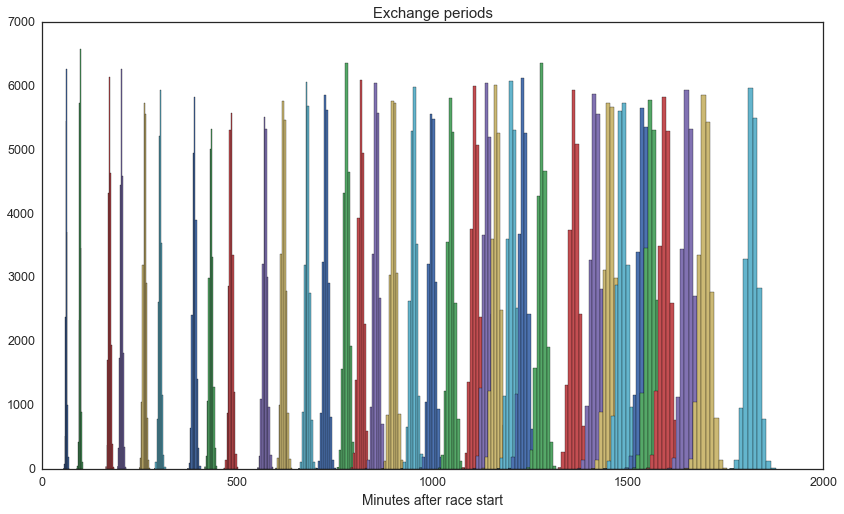

In [181]:
[plt.hist(periods[i]) for i in np.arange(R*3)]
plt.xlabel("Minutes after race start")
plt.title("Exchange periods")

In [151]:
intervals = np.mean(periods, axis=1) + (np.ones((36,3)) * np.array([-2,0,2])).T * np.std(periods, axis=1)

In [189]:
start_time = datetime(2016,5,13,6,30,0)
interval_times = start_time + np.vectorize(lambda t: timedelta(minutes=t))(intervals).T
strf = "%d %B %Y %H:%M %p"
print "Start is expected at %s" % (start_time.strftime(strf),)
for i in np.arange(len(interval_times)):
    int_start = interval_times[i,0].strftime(strf)
    int_end = interval_times[i,2].strftime(strf)
    if i < len(interval_times) - 1:
        print "Exchange %d (%s to %s) is expected:" % (i+1, init_paces.loc[(i%R)+1]['name'],init_paces.loc[((i+1)%R)+1]['name'])
    else: 
        print "Exchange %d (finish) is expected:" % (i+1,) 
    print "         between %s and %s." % (int_start, int_end)

Start is expected at 13 May 2016 06:30 AM
Exchange 1 (David to Anna) is expected:
         between 13 May 2016 07:28 AM and 13 May 2016 07:35 AM.
Exchange 2 (Anna to Kevin) is expected:
         between 13 May 2016 08:03 AM and 13 May 2016 08:10 AM.
Exchange 3 (Kevin to Christine) is expected:
         between 13 May 2016 09:17 AM and 13 May 2016 09:28 AM.
Exchange 4 (Christine to Daniel) is expected:
         between 13 May 2016 09:47 AM and 13 May 2016 09:59 AM.
Exchange 5 (Daniel to Jason) is expected:
         between 13 May 2016 10:44 AM and 13 May 2016 10:59 AM.
Exchange 6 (Jason to Valerie) is expected:
         between 13 May 2016 11:24 AM and 13 May 2016 11:39 AM.
Exchange 7 (Valerie to Patrick) is expected:
         between 13 May 2016 12:50 PM and 13 May 2016 13:08 PM.
Exchange 8 (Patrick to Mark) is expected:
         between 13 May 2016 13:32 PM and 13 May 2016 13:51 PM.
Exchange 9 (Mark to Chris) is expected:
         between 13 May 2016 14:24 PM and 13 May 2016 14:42 PM.